# Chatbot with Profile Schema

In [1]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

In [2]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"]
}
user_profile

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

In [3]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

In [4]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}, 'created_at': '2025-08-12T22:18:57.938102+00:00', 'updated_at': '2025-08-12T22:18:57.938104+00:00', 'score': None}


In [5]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

In [10]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain.chat_models import init_chat_model

model = init_chat_model(
    "anthropic.claude-3-5-sonnet-20241022-v2:0",
    model_provider="bedrock_converse",
)

# from langchain_aws import ChatBedrock
# import boto3

# session = boto3.Session(profile_name="default")
# bedrock_client = session.client('bedrock-runtime')

# model_id = 'anthropic.claude-3-haiku-20240307-v1:0'
# # model_id = "meta.llama3-8b-instruct-v1:0"
# model_kwargs =  { 
#         "max_tokens": 512,
#         "temperature": 0,
#         "top_p": 1,
# }

# LangChain class for chat
# model = ChatBedrock(
#     client=bedrock_client,
#     model_id=model_id,
#     model_kwargs=model_kwargs,
# )



# Initialize the model

# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
structured_output

{'user_name': 'Lance', 'interests': ['biking']}

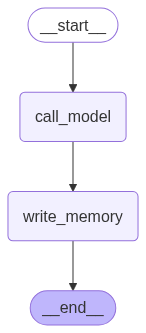

In [11]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [12]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.
================================== Ai Message ==================================

Hello Lance! Nice to meet you. Since I don't have any previous memory stored about you, I'll remember that you enjoy biking around San Francisco and visiting bakeries - those are great activities to combine! San Francisco has some excellent bakeries and cycling culture. Do you have any favorite bakery spots you like to bike to in the city? I'd be happy to engage in conversation about SF bakeries, cycling routes, or other topics that interest you.


In [13]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance', 'interests': ['biking', 'bakeries', 'San Francisco']}

In [14]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="I really like biking around San Francisco.")]

In [15]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

In [16]:

from trustcall import create_extractor

# Schema 
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize the model
from langchain.chat_models import init_chat_model

model = init_chat_model(
    "anthropic.claude-3-5-sonnet-20241022-v2:0",
    model_provider="bedrock_converse",
)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

In [17]:
for m in result["messages"]: 
    m.pretty_print()


================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'UserProfile', 'input': {'user_name': 'Lance', 'interests': ['biking', 'San Francisco']}, 'id': 'tooluse_AWwyCGj1THKewcTi44H5mQ'}]
Tool Calls:
  UserProfile (tooluse_AWwyCGj1THKewcTi44H5mQ)
 Call ID: tooluse_AWwyCGj1THKewcTi44H5mQ
  Args:
    user_name: Lance
    interests: ['biking', 'San Francisco']


In [18]:
schema = result["responses"]
schema

[UserProfile(user_name='Lance', interests=['biking', 'San Francisco'])]

In [19]:
schema[0].model_dump()

{'user_name': 'Lance', 'interests': ['biking', 'San Francisco']}

In [20]:
result["response_metadata"]

[{'id': 'tooluse_AWwyCGj1THKewcTi44H5mQ'}]

In [21]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Lance."), 
                        AIMessage(content="Nice to meet you, Lance."), 
                        HumanMessage(content="I really like biking around San Francisco."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})  

In [22]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'UserProfile', 'input': {'user_name': 'Lance', 'interests': ['biking', 'bakeries', 'San Francisco']}, 'id': 'tooluse_NXiYb5fYQZ-_45qoflZ9sw'}]
Tool Calls:
  UserProfile (tooluse_NXiYb5fYQZ-_45qoflZ9sw)
 Call ID: tooluse_NXiYb5fYQZ-_45qoflZ9sw
  Args:
    user_name: Lance
    interests: ['biking', 'bakeries', 'San Francisco']


In [23]:
result["response_metadata"]

[{'id': 'tooluse_NXiYb5fYQZ-_45qoflZ9sw'}]

In [24]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Lance', 'interests': ['biking', 'bakeries', 'San Francisco']}

In [24]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='morse code', sentence_preference_revealed='morse code')], favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Daredevil')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='straight key')], favorite_morse_abbreviations=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Daredevil')]), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed='higher')], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='diamond formation'

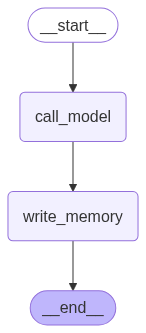

In [25]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
from langchain.chat_models import init_chat_model
model = init_chat_model(
    "anthropic.claude-3-5-sonnet-20241022-v2:0",
    model_provider="bedrock_converse",
)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [26]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello Lance! Nice to meet you. Since this is our first interaction, I don't have any previous memory about you, but I'll be happy to get to know you better and provide personalized assistance. Is there anything in particular I can help you with today?


In [27]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That's great information, Lance! I now know that you enjoy cycling and are located in San Francisco. San Francisco is an excellent city for biking, although those hills can be quite challenging! 

Would you like some recommendations for popular bike routes in SF? There are some great paths like the Golden Gate Bridge to Sausalito route, the Embarcadero waterfront, or riding through Golden Gate Park. 

Also, since you enjoy biking, I'm curious - do you bike primarily for recreation, commuting, or both? This will help me provide better personalized recommendations for you in the future.


In [28]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Lance',
  'user_location': 'San Francisco',
  'interests': ['biking']},
 'created_at': '2025-08-12T22:21:14.497930+00:00',
 'updated_at': '2025-08-12T22:21:14.497931+00:00'}

In [29]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['biking']}

In [30]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

That's a great combination - biking and bakeries! San Francisco has some amazing bakeries, and biking to them is a perfect way to balance out those delicious treats. Since I know you're in San Francisco and enjoy both biking and bakeries, I can suggest some popular spots:

1. Tartine Bakery in the Mission
2. Arsicault Bakery in the Richmond (known for their croissants)
3. B. Patisserie in Pacific Heights
4. Mr. Holmes Bakehouse in the Tenderloin
5. Acme Bread Company at the Ferry Building

You could even plan a "bakery bike tour" hitting multiple spots - it's a fun way to explore different neighborhoods while enjoying some of the city's best baked goods! Would you like specific recommendations for bike-friendly routes to any of these bakeries?

I'll remember that you enjoy bakeries along with b

In [31]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Given that you're in San Francisco and interested in bakeries, I have several excellent recommendations for you, Lance!

Here are some of San Francisco's best bakeries:

1. Tartine Bakery (Mission District) - Famous for their morning buns and country bread
2. b. patisserie (Pacific Heights) - Known for their kouign amann and French pastries
3. Arsicault Bakery (Richmond/Hayes Valley) - Named "Best Croissant in America" by Bon Appétit
4. Mr. Holmes Bakehouse (Multiple locations) - Famous for their "cruffins" and creative pastries
5. Jane the Bakery (Multiple locations) - Great bread and pastries, plus you could bike there!

Since you enjoy biking, you could make a fun day out of visiting several of these spots by bicycle. The route from the Mission to Pacific Heights to the Richmond woul